# Verification, Validation, and SciML

## **Jed Brown**, CU Boulder


## 2024-12-09

In [12]:
using Plots
default(linewidth=3)
using LinearAlgebra

function vander(x, k=nothing)
    if k === nothing
        k = length(x)
    end
    V = ones(length(x), k)
    for j = 2:k
        V[:, j] = V[:, j-1] .* x
    end
    V
end

function fdstencil(source, target, k)
    "kth derivative stencil from source to target"
    x = source .- target
    V = vander(x)
    rhs = zero(x)'
    rhs[k+1] = factorial(k)
    rhs / V
end

function poisson_fd(x, spoints, forcing; left=(0, zero), right=(0, zero))
    n = length(x)
    L = zeros(n, n)
    rhs = forcing.(x)
    for i in 2:n-1
        jleft = min(max(1, i-spoints÷2), n-spoints+1)
        js = jleft : jleft + spoints - 1
        L[i, js] = -fdstencil(x[js], x[i], 2)
    end
    L[1,1:spoints] = fdstencil(x[1:spoints], x[1], left[1])
    L[n,n-spoints+1:n] = fdstencil(x[n-spoints+1:n], x[n], right[1])
    rhs[1] = left[2](x[1])
    rhs[n] = right[2](x[n])
    L, rhs
end

poisson_fd (generic function with 1 method)

# 38 years ago: [Journal of Fluids Engineering](https://jedbrown.org/files/RoacheGhiaWhite-JFEEditorialPolicyStatementControlOfNumericalAccuracy-1986.pdf)

<img src="figures/JFENumericalAccuracy.png" width="90%" />

* “it was impossible to compare the
accuracy of different turbulence
models, since one could not
distinguish physical modeling errors
from numerical errors related to the
algorithm and grid.”

<img src="figures/JFENumericalAccuracy2.png" width="90%" />

# Verification

## solving the problem right

# Validation

## solving the right problem

Verification is a mathematical activity that can, in principle, be completed (though one must always establish sufficient resolution). Validation is always ongoing, subject to tolerances and regime.

# [PDEBench (2022)](https://github.com/pdebench/PDEBench/)

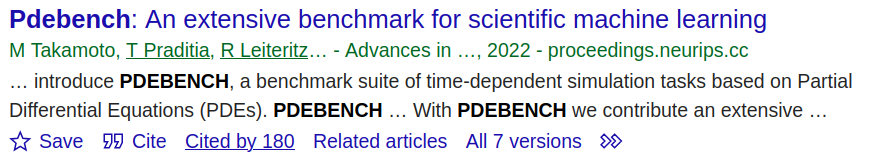

The parameters in the paper claims to model 3D turbulence at Reynolds number $10^8$ using a $64\times 64\times 64$ grid and a second-order spatial discretization.

* Simulation cost scales as $\textrm{Re}^3$.
* $\textrm{Re} \approx 10^8$ is about a billion times more expensive than the largest simulations that have been today.
* The $64^3$ resolution has been feasible for nearly 50 years

## Conclusion

The benchmark result intended for use is nonsense.

# How does one go about Verification?

# Consistency + Stability = Convergence

## Consistency

When we apply the differential operator to the exact solution, we get a small residual.

The residual converges under grid refinement.

Hopefully asymptotically fast.

## Stability

There do not exist “bad” functions that also satisfy the equation.

This gets subtle for problems like incompressible materials or contact mechanics.

These are foundational theoretical tools, and can often be tested in practice (e.g., "patch tests"), but
* it doesn't establish that the code works
* it's not possible to prove convergence for many real-world problems
* there are open research questions about whether numerous important problems are even well-posed

# Empirical measurement of convergence

## Convergence on a problem with analytic solution

* These can be great, but solutions of nonlinear equations are extremely hard to find.
* Such solutions usually have many symmetries and rarely activate all terms.

## Self-convergence

* Just set up a problem and solve it on a sequence of meshes, use a refined solution as reference (perhaps using Richardson extrapolation), then plot error.
* You've checked that the code convergences to **some solution**, not the **correct solution**.
  * You could have a factor of 2 typo, or more serious mistakes.


# Method of Manufactured Solutions (MMS)

Pick any smooth function with rich derivatives,
$$u(x) = \tanh(x).$$
Then differentiate (analytically, symbolically, or algorithmically) to create a (non-physical) "body force"
\begin{align*}
u'(x) &= \cosh^{-2}(x) \\
u''(x) &= -2\tanh(x) \cosh^{-2}(x). \\
\end{align*}

<img src="figures/elast-b4q5.png" />

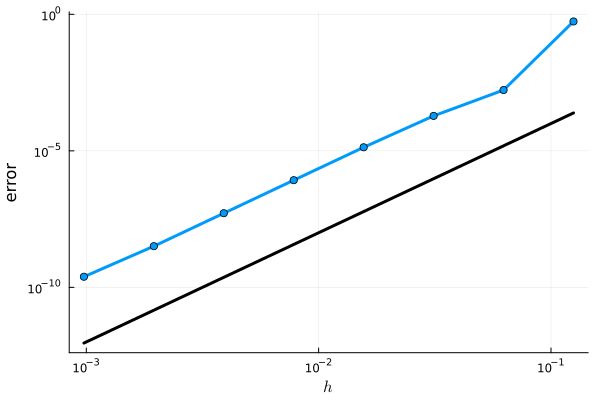

In [18]:
ns = 2 .^ (3:10); hs = 1 ./ ns; order = 4
function poisson_fd_error(n; spoints=3)
    x = LinRange(-2, 2, n)
    L, rhs = poisson_fd(x, spoints, x -> 2 * tanh(x) / cosh(x)^2,
        left = (0, tanh),
        right = (1, x -> cosh(x)^-2))
    u = L \ rhs
    norm(u - tanh.(x), Inf)
end
plot(hs, [poisson_fd_error(n, spoints=order+1) for n in ns], marker=:circle, xlabel="\$h\$", ylabel="error")
plot!(h -> h^order, color=:black, xscale=:log10, yscale=:log10, legend=:none)


# How reliable is MMS?

* Salari and Knupp (2000) report an blind study of attempted sabotage (by creating bugs) of a CFD code (compressible and incompressible Navier-Stokes) that had been verified using MMS. Of the 21 cases studied, every error that affected solution accuracy was detected. (MMS does not detect memory leaks, etc.)

* You need to be able to implement non-physical forcing terms and boundary conditions. As such, you can't "train" on data from physical experiments (which would be jumping to validation).
* There are some technical issues with singular or under-resolved problems (shocks, material discontinuities).


# CFD 2030/why is it so important to be correct?

Modeling and simulation is used to plan at the greatest scale.

* Dams, bridges
* Toxic/nuclear waste management
* Nuclear stockpile stewardship
* Climate policy/water resource management/reinsurance
* Airplanes, etc.

**We can't just 3d print a bunch of widgets and load test them. Tests are expensive (billions over many years) or worse.**

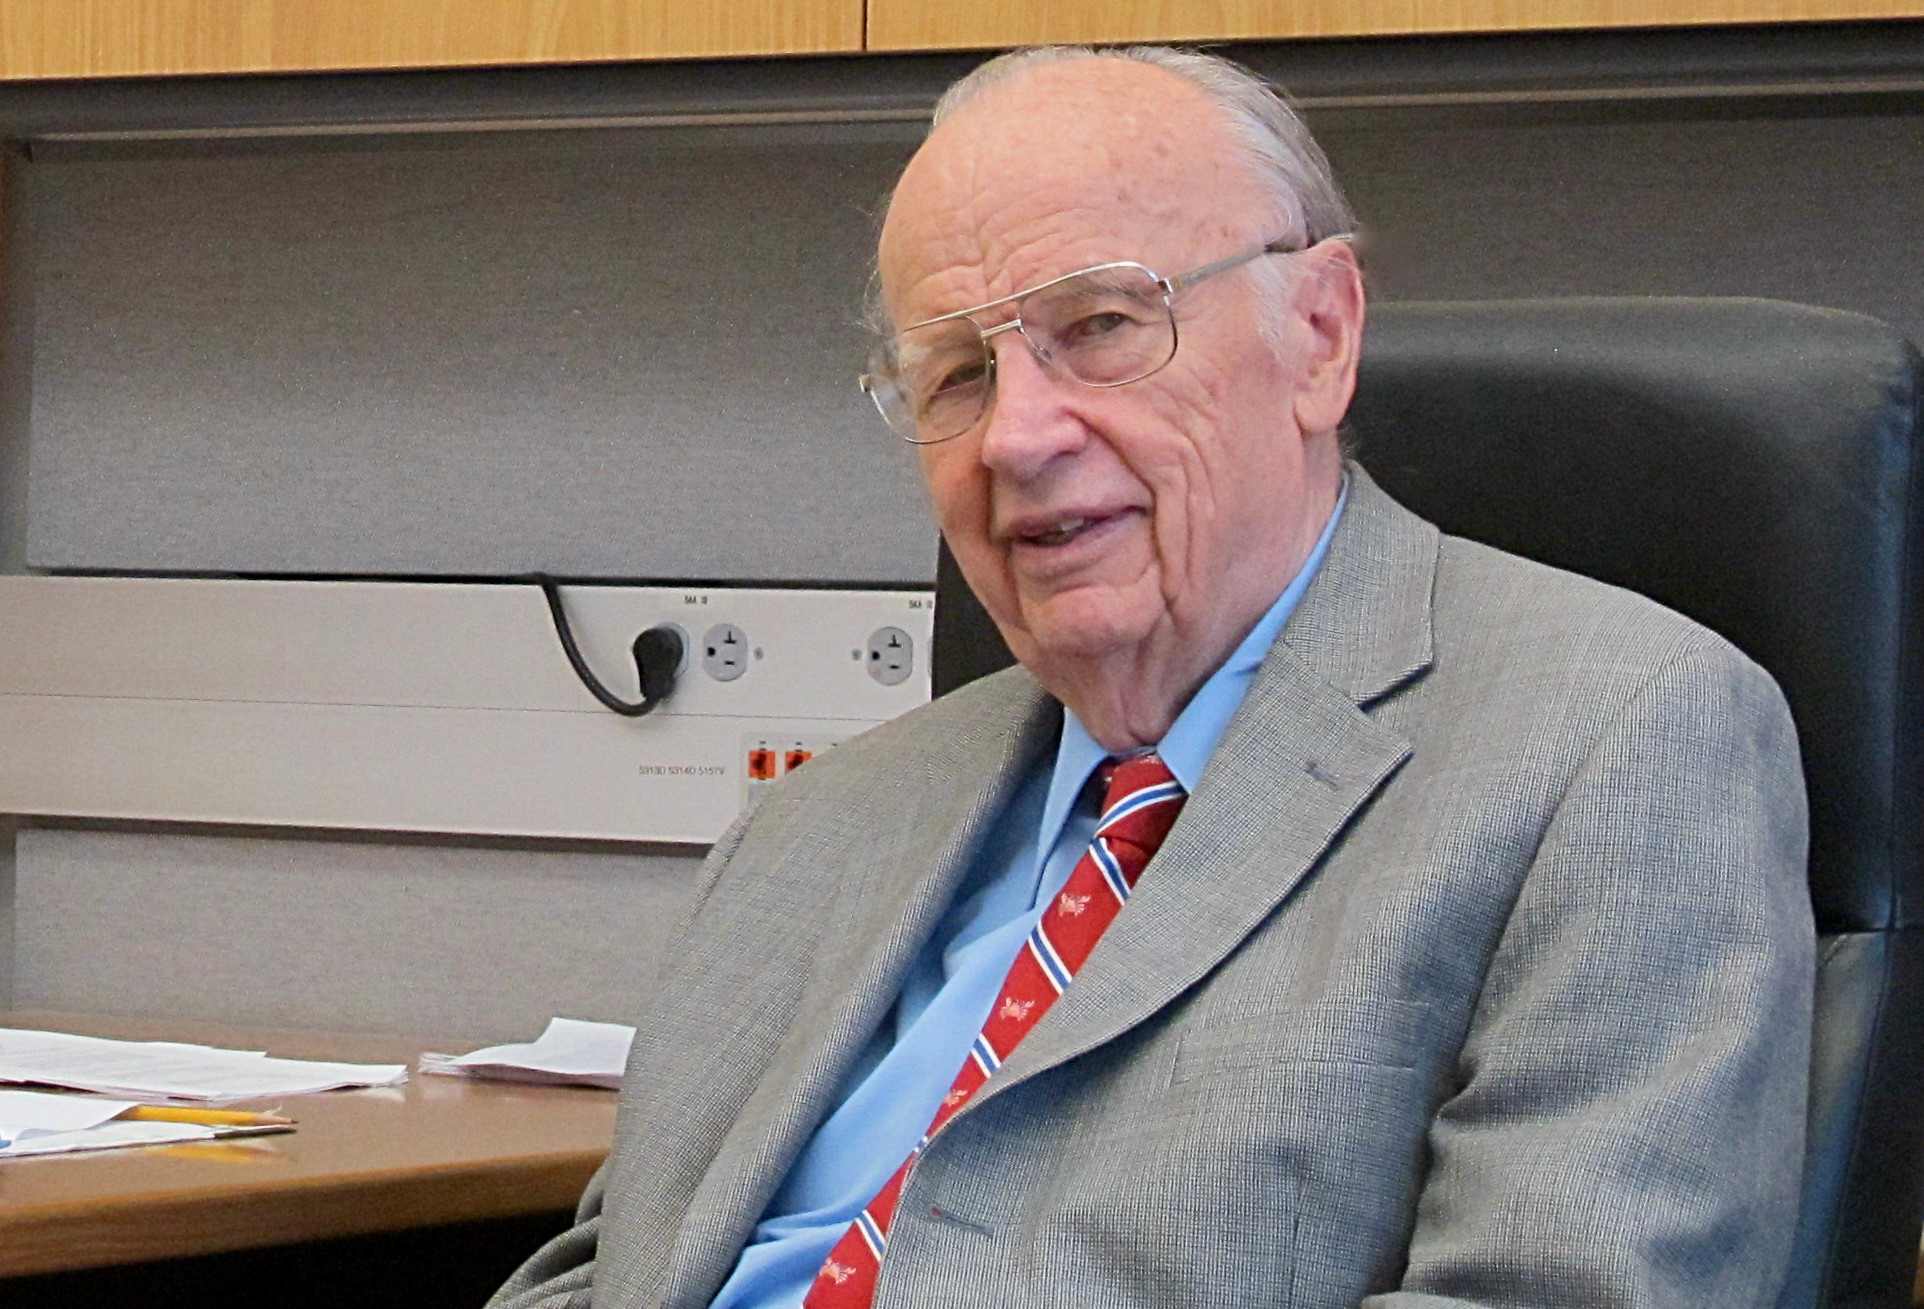

## Will you sign the blueprint?

-- Ivo Babuška

# Definition of ML (or AI)

# [NAIRR definition (2023)](https://www.ai.gov/wp-content/uploads/2023/01/NAIRR-TF-Final-Report-2023.pdf)

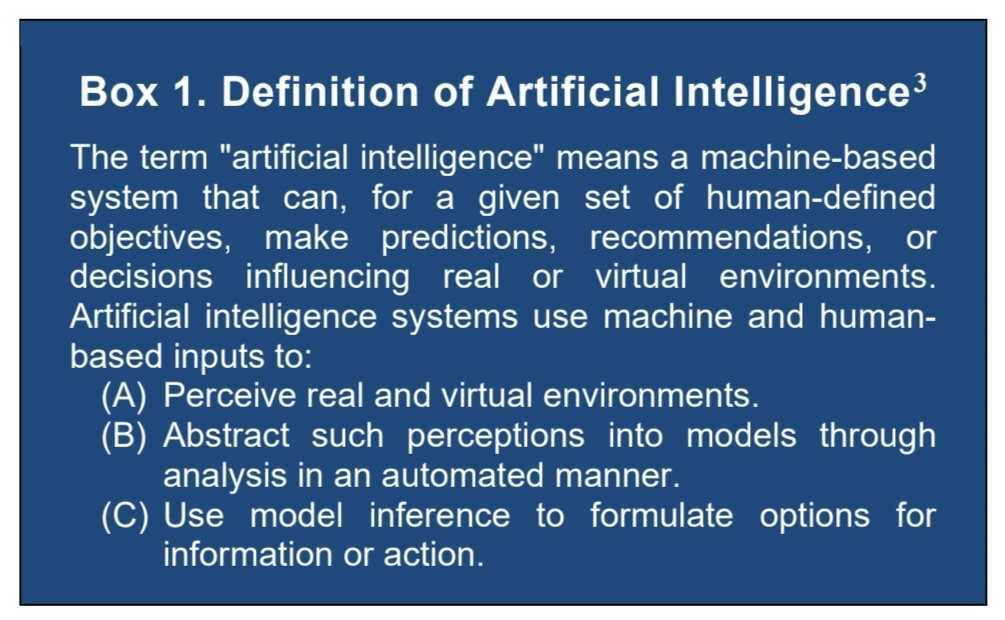

![](figures/tap-the-sign-nwp-ai.png)

# Naranayan and Kappor (2024)

> 1. Does the task require creative effort or training for a human to perform? [page 12]
> 2. Was the behavior of the system directly specified in code by the developer, or did it indirectly emerge, say by learning from examples or searching through a database? [page 13]
> 3. … whether the system makes decisions more or less autonomously and possesses some degree of flexibility and adaptability to the environment. [page 13]


![](figures/tap-the-sign-nwp-ai.png)

# Is it even techical?

> AI (or ML) is not a well-defined technology, but a cultural affinity signal of disregard for harms resulting from shoddy systems.

-- me (past several years)

> I think we should shed the idea that AI is a technological artifact with political features and recognize it as a political artifact through and through. AI is an ideological project to shift authority and autonomy away from individuals, towards centralized structures of power.

-- [Ali Alkhatib: Defining AI (2024)](https://ali-alkhatib.com/blog/defining-ai)

# De-facto technical definition

## Machine Learning is whatever is not-too-awkward to implement in PyTorch/JAX today.

## Excludes

* Adaptive algorithms (in number of steps, "layer" shape, etc.)
* Many "implicit layers", unless the right person implemented/published them.

## Social harms

* "we'll know it when we see it" gives license to ignore prior work and expertise
* it diverts funding from well-founded abstractions and systems
* allows selling all manner of "magical thinking"
* captures control

# McGreivy and Hakkim (2024)
## Weak baselines and reporting biases lead to overoptimism in machine learning for fluid-related partial differential equations

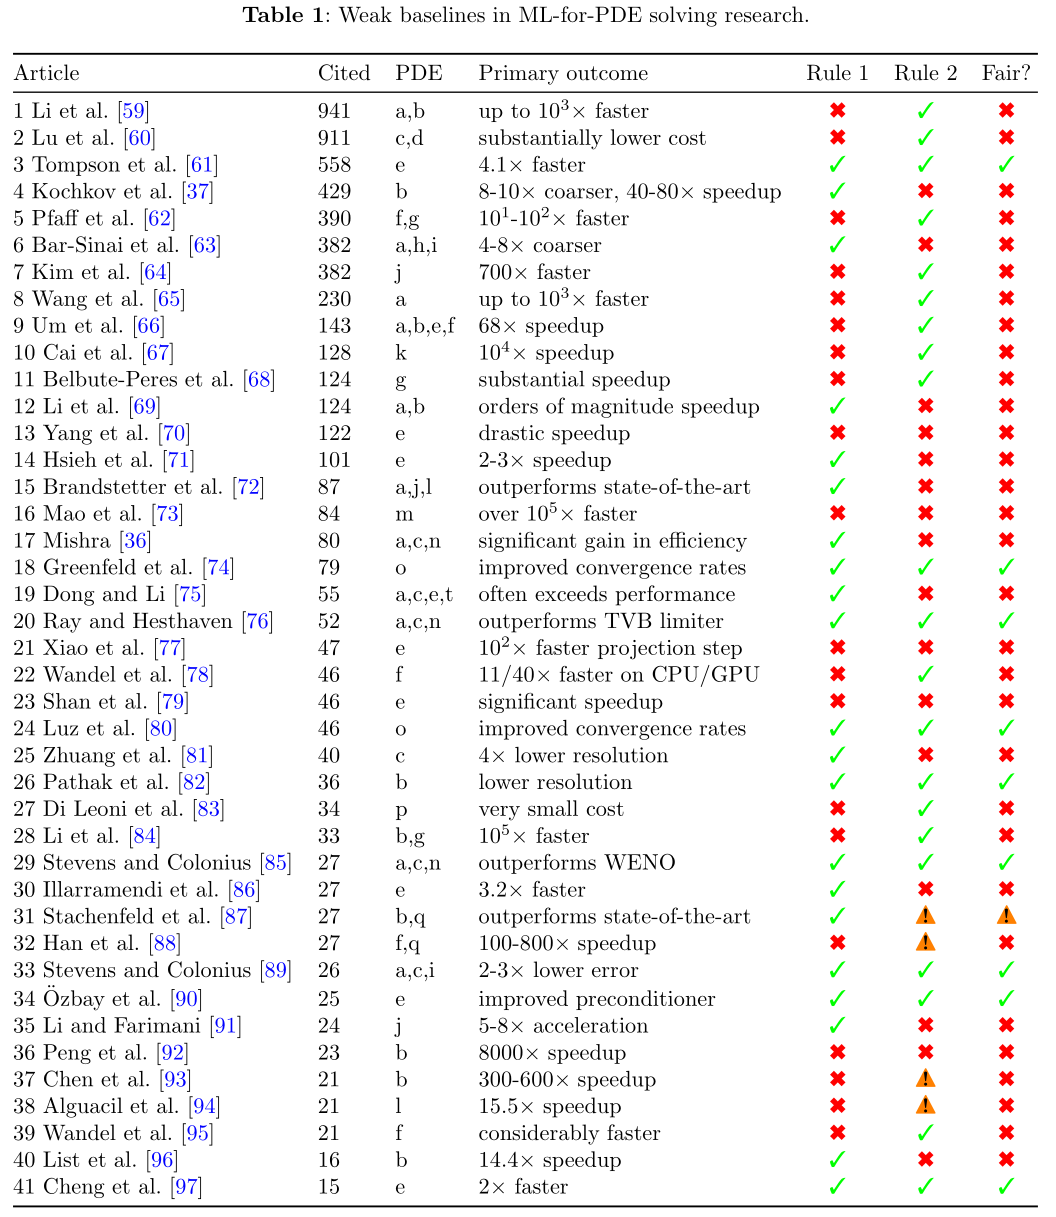

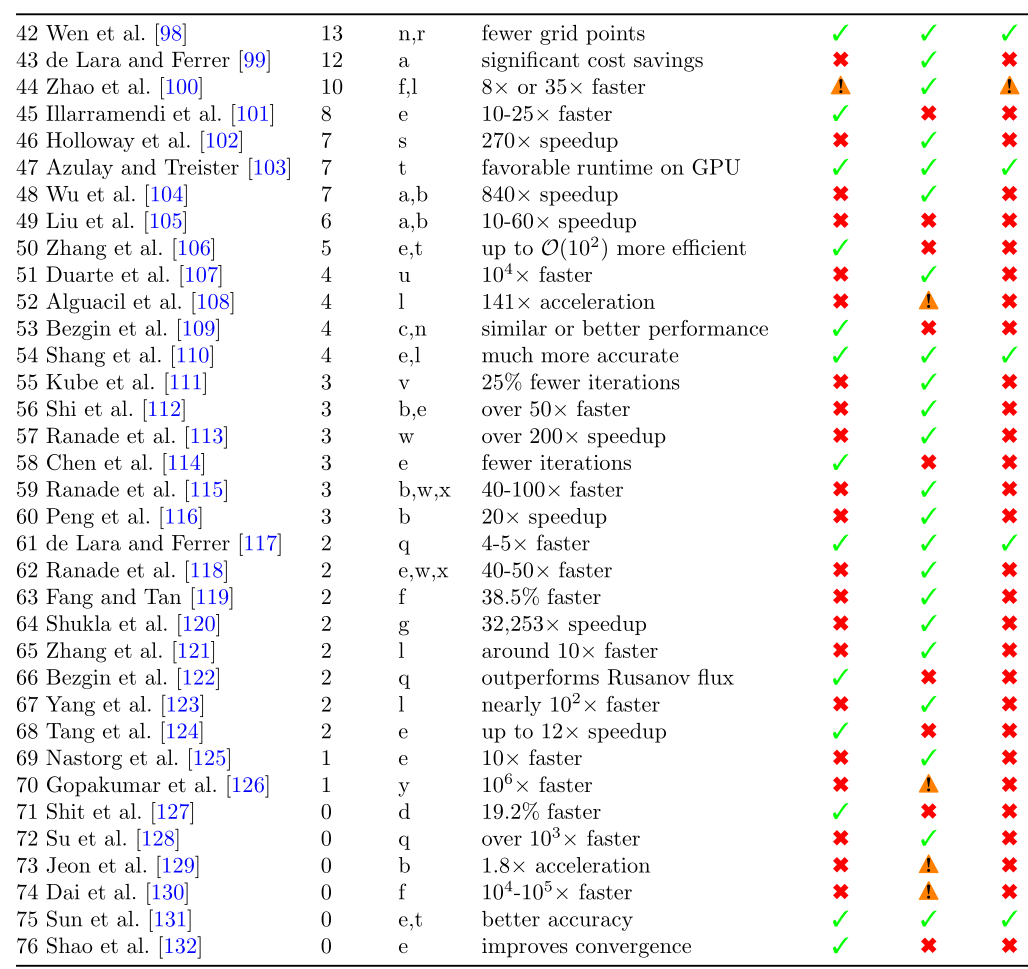

<img src="figures/mechanism-data.png" width="60%" />

# CRIKit: constitutive relation inference

<img src="figures/crikit-workflow.svg" width="90%" />